# Model fitting. Determine Teff and log(g).

In [1]:
import sys
sys.path.append('/mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject')

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.interpolate import CubicSpline
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from typing import Iterable

from import_data import BailerJones
from model_functions import *
from functions import import_spectra, extract_spectrum_within_range

Import models and spectrum (~21 seconds)

In [2]:
# Import models for given galaxy
models = import_models('Milkyway')
# Import spectrum of given object
spectra = import_spectra('4U1538_52')

# Name of object
object_name = '4U1538-52'
# Distance to object
distance = BailerJones().loc[BailerJones().id == object_name]['r_med_photogeo'].reset_index(drop=True).at[0]

In [3]:
def select_spectrum(spectra: list, central_wav: float)->tuple:
    """
    Select the spectrum containing the given spectral line

    Args:
        spectra (list): List of spectra, made by import_spectra(object)
        central_wav (float): Central wavelenght of the spectral line

    Returns:
        tuple: wavelength, flux
    """
    for spectrum in spectra:
        if central_wav >= min(spectrum[0])  and central_wav <= max(spectrum[0]):
            return spectrum[0], spectrum[1]



def extract_continuum(wavelengths: np.array, flux: np.array, start: float, end: float, line_left: float, line_right: float)->tuple:
    """
    Extract continuum from spectrum

    Args:
        wavelengths (np.array): List with wavelength
        flux (np.array): List with flux
        start (float): Start of spectrum
        end (float): End of spectrum
        line_left (float): Start spectral line
        line_right (float): End spectral line

    Returns:
        tuple: (Wavelength, Flux)
    """
    # Find indices corresponding to the specified wavelength range
    indices_left = np.where((wavelengths >= start) & (wavelengths <= line_left))[0]
    indices_right = np.where((wavelengths >= line_right) & (wavelengths <= end))[0]
    indices = np.concatenate((indices_left, indices_right))

    # Extract wavelength and flux values within the range
    extracted_wavelengths = wavelengths[indices]
    extracted_flux = flux[indices]

    return extracted_wavelengths, extracted_flux

In [4]:
filtered_models = models_in_interval(models, 30000, 35000, 3.0, 3.2)

In [5]:
def chi_squared(wav_model, flux_model, wav_line, flux_line, SNR):

    # Get the flux for every wavelenght of the data.
    # Create a CubicSpline object
    cubic_spline = CubicSpline(wav_model, flux_model)

    # Interpolate intensity at the desired wavelengths
    flux_model_inter = cubic_spline(wav_line)

    # Calculate chi-squared
    chi_squared = 0
    for i in range(len(flux_line)):
        chi_squared += ( (flux_model_inter[i] - flux_line[i]) / (1 / SNR) ) ** 2
    chi_squared /= len(wav_line)

    return chi_squared

In [6]:
# List with the lines that are appropriate to fit a gauss
# lines: [wavelength, name, continuum left, line left, line right, continuum right]
_4U1538_52 = {
    'lines': [
        [4340.46, r"H$\gamma$: 4340.46", 4325, 4335, 4340.7, 4347],
        [4387.93, r"He I: 4387.93", 4381, 4383.75, 4388.20, 4393],
        [4471.50, r"He I: 4471.50", 4459, 4466.2, 4472, 4477.5],
        [4713.17, r"He I: 4713.17", 4703, 4708.5, 4713, 4717],
        [4861.33, r"H$\beta$: 4861.33", 4845, 4854.5, 4862, 4870], 
        [4921.93, r"He I: 4921.93", 4910, 4916, 4922.4, 4932],
        [5015.68, r"He I: 5015.68", 5000, 5010.4, 5016, 5024],
    ],
    'Doppler_guess': 2.8
}

In [7]:
def gaussian(x: list, mean: float, amplitude: float, stddev: float, continuum: float)->list:
    """
    Gauss

    Args:
        x (list): Data
        mean (float): mu
        amplitude (float): amplitude
        stddev (float): sigma
        continuum (float): c parameter

    Returns:
        list: y-values of gauss
    """
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2) + continuum

In [8]:
def determine_doppler_shift(spectra: list, lines: dict, guassian: callable, plot: bool=False)->list:
    """
    This function takes a spectra and list with lines (and their ranges)
    and fits a gaussian to these lines to determine the doppler shift of
    the spectrum.

    Args:
        spectra (list): Spectra of the object (UVES)
        lines (dict): Spectral lines and their ranges
        guassian (callable): Function of a gaussian
        plot (bool, optional): If true, the fits to the data are shown. Defaults to False.

    Returns:
        list: All doppler shift of the individual lines.
    """
    ## FIT ALL LINES
    # Dictionary to save the fit results.
    fit_results = {}

    # Fit a gauss to all spectral lines
    for line in lines['lines']:
        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)

        # Extract the spectral line from the spectrum
        wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
        wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
        wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])

        # Initial guess for the parameters
        initial_guess = [line[0] - lines['Doppler_guess'], # mu
                        max(flux)/min(flux), # amplitude
                        (max(wav_line) - min(wav_line)) / 4, # stddev
                        np.mean(flux_cont)] # continuum height

        # Fit the data
        params, covariance = curve_fit(gaussian, wav, flux, p0=initial_guess)

        # Save results
        fit_results[line[1]] = {"spectrum": (wav, flux),
                                "continuum": (wav_cont, flux_cont),
                                "line": (wav_line, flux_line),
                                "fit_result": (params, covariance),
                                "rest_wavelength": line[0]}


    ## DETERMINE THE DOPPLER SHIFT
    # Calculate the dopplershift for every line
    doppler_shift = []
    for line, data in fit_results.items():
        lambda0 = data['rest_wavelength']
        delta_lambda = data['fit_result'][0][0] - lambda0
        velocity = delta_lambda / lambda0 * 3E5 # km/s
        doppler_shift.append(velocity)

    print(doppler_shift)
    print(f'The velocity of the object is: {np.mean(doppler_shift)} +- {np.std(doppler_shift)}')


    ## PLOT THE FIT RESULTS
    if plot:
        num_plots = len(fit_results)
        num_rows = (num_plots - 1) // 4 + 1  # Calculate the number of rows needed

        fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))

        # Flatten axes if necessary
        if num_rows == 1:
            axes = [axes]

        for i, ax_row in enumerate(axes):

            for j, ax in enumerate(ax_row):
                plot_index = i * 4 + j

                if plot_index < num_plots:
                    key = list(fit_results.keys())[plot_index]
                    wav, flux = fit_results[key]['spectrum']
                    fit = gaussian(wav, *fit_results[key]['fit_result'][0])

                    ax.plot(wav, flux, color='blue', label='spectrum')  # Plot your data here
                    ax.plot(wav, fit, color='orange', label='fit')
                    ax.vlines(fit_results[key]['fit_result'][0][0], ymin=min(fit), ymax=max(fit),
                            label=(r'$\mu$ = ' + f"{round(fit_results[key]['fit_result'][0][0], 2)}" + r'$\AA$'), color='red')
                    ax.set_title(f'{key}')
                    ax.legend(fontsize=8)

                else:
                    ax.axis('off')  # Turn off axis for unused subplots
                
                if j == 0:
                    ax.set_ylabel('flux', size=12)
                if i == len(axes) - 1:
                    ax.set_xlabel(r'Wavelength ($\AA$)', size=12)

        plt.suptitle(f"{object_name}\nRadial velocity: {round(np.mean(doppler_shift), 2)}" + r" $\pm$ " + f"{round(np.std(doppler_shift), 2)}" + r" km $s^{-1}$", size=20)
        plt.tight_layout()
        plt.show()

    return doppler_shift

In [9]:
def doppler_shift_spectrum(wavelengths:Iterable[float], vrad:float)->Iterable[float]:
    return [(i * (vrad / 299792.458 + 1)) for i in wavelengths]

In [10]:
def chi_squared_for_all_models(spectra:list, models:dict, lines:dict, SNR: float, vrad: float, vsini: float)->dict:
    """
    Determines the chi-squared for every model for the given spectral lines.

    Args:
        spectra (list): The spectra of the object (UVES)
        models (dict): Dictionary with the models
        lines (dict): Dictionary with the lines and their ranges
        SNR (float): Signal to noise ratio of the spectrum
        doppler_shift (float): The doppler_shift of the object in km/s
        vsini (float): the vsini parameter of the object in km/s

    Returns:
        dict: Dictionary with the chi-squared for every model
    """
    chi2 = {}

    for key, model in models.items():
        print(f"\rIteration {key}", end='', flush=True)
        # Chi-squared parameter
        chi2[key] = 0

        for line in lines['lines']:
            # Rest wavelength of the spectral line
            central_wavelength = line[0]

            # Select the spectrum that contains the spectral line
            wav, flux = select_spectrum(spectra, central_wavelength)

            # Extract the spectral line from the spectrum
            wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
            wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
            wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])
            # Extract the line from the model
            wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

            # Linear fit to continuum
            cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
            # Normalize spectrum
            flux /= cont_fit(wav)
            flux_cont /= cont_fit(wav_cont)
            flux_line /= cont_fit(wav_line)

            # Dopplershift the model
            wav_model = doppler_shift_spectrum(wav_model, vrad)

            # Apply doppler broadening
            wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
            flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, vsini)

            chi2[key] += chi_squared(wav_model, flux_model, wav_line, flux_line, SNR)

        # Devide the total chi-squared by the number of lines.
        chi2[key] /= len(lines['lines'])

    print("DONE", end='', flush=True)
    return chi2

In [11]:
def plot_best_model(spectra: list, models:dict, lines:dict, best_model:str)->None:
    """
    Plots the best model over the spectrum

    Args:
        spectra (list): Spectrum of the object (UVES)
        models (dict): All models
        lines (dict): List with all lines and their ranges
        best_model (str): Model with the lowest chi-squared
    """
    model = models[best_model]
    for line in lines['lines']:
        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)

        # Extract the spectral line from the spectrum
        wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
        wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
        wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])
        # Extract the line from the model
        wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

        # Linear fit to continuum
        cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
        # Normalize spectrum
        flux /= cont_fit(wav)
        flux_cont /= cont_fit(wav_cont)
        flux_line /= cont_fit(wav_line)

        # Dopplershift the model
        flux_model, wav_model = pyasl.dopplerShift(wav_model, flux_model, -80., edgeHandling="firstlast")

        # Apply doppler broadening
        wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
        flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, 166.2297987071765)

        plt.plot(wav, flux, color='blue', alpha=0.2)
        plt.plot(wav_line, flux_line, color='orange', alpha=0.2)
        plt.plot(wav_model, flux_model, color='green', label=f'{best_model}')

        # Annotate each line with text vertically
        plt.text(line[0], max(flux), line[1], ha='center', va='bottom', rotation=90, size=7)
    plt.legend()
    plt.show()

    return

##### Determine the overall doppler shift

[-167.22721147877763, -145.8445988035299, -177.66977115226172, -166.39814183727918, -185.04045378927998, -159.28411175173233, -162.14430213737472]
The velocity of the object is: -166.2297987071765 +- 11.748720966404955


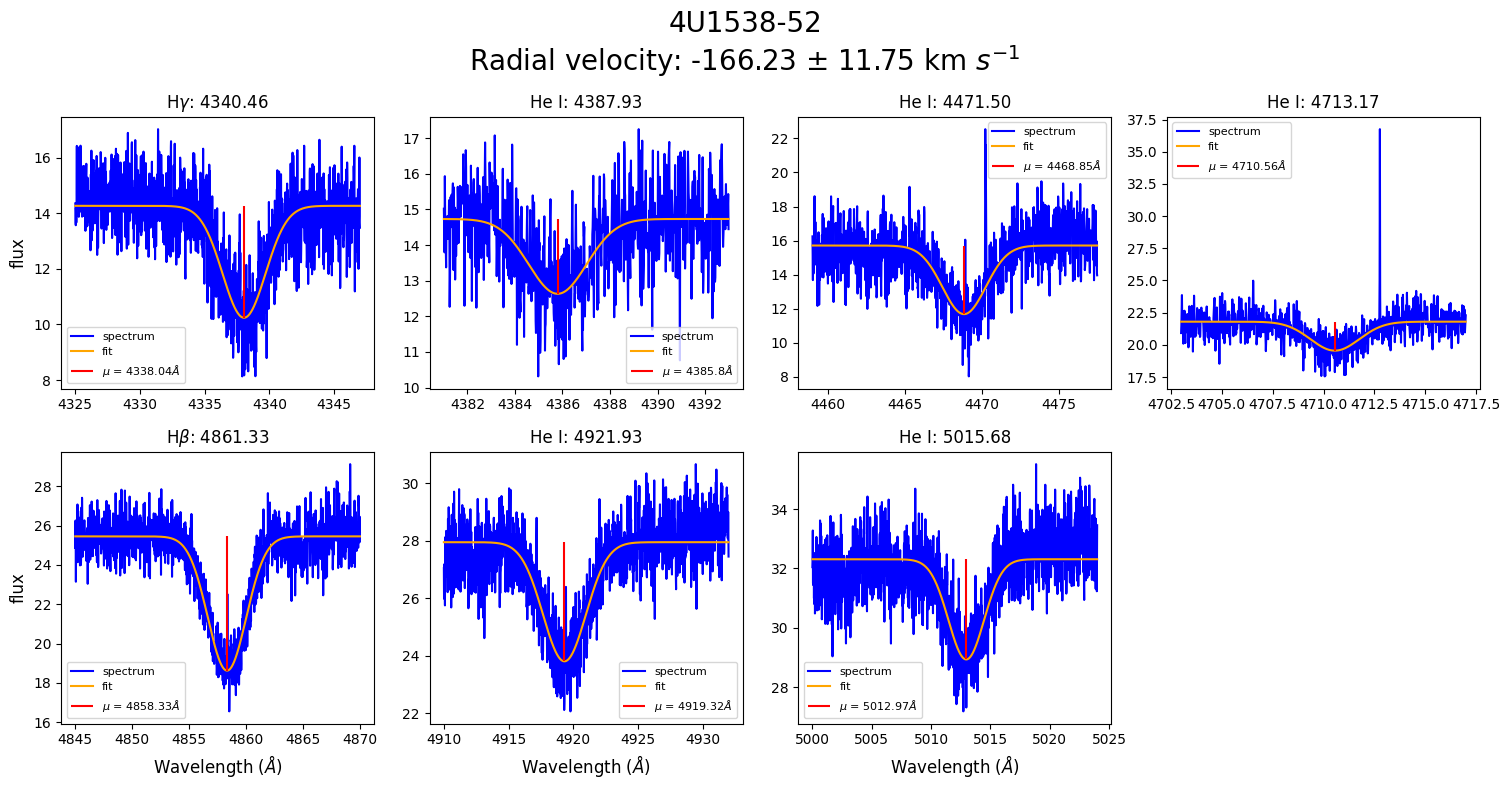

In [12]:
doppler_shifts = determine_doppler_shift(spectra, _4U1538_52, gaussian, True)

##### Calculate $\chi^{2}$ for all lines and all models.

In [13]:
chi2 = chi_squared_for_all_models(spectra, models, _4U1538_52, SNR=9, vrad=-166.2297987071765, vsini=180.)

Iteration T56000logg4.2DONE

##### $\chi^{2}$ analysis

In [14]:
# Define the desired logg value for filtering
desired_logg = 3.2

# Filter the model names based on the logg value
filtered_models_dict = {model_name: model_description for model_name, model_description in chi2.items() 
                        if extract_temperature_and_gravity(model_name)[1] == desired_logg}

# Print the filtered model names
print("Model names with logg value", desired_logg, ":", filtered_models_dict)

Model names with logg value 3.2 : {'T16000logg3.2': 1.4447307534529024, 'T17000logg3.2': 1.3003125284917416, 'T18000logg3.2': 1.2168635292566312, 'T19000logg3.2': 1.0893129295948387, 'T20000logg3.2': 0.9332025641346151, 'T21000logg3.2': 0.8433227551579405, 'T22000logg3.2': 0.7511028725062374, 'T23000logg3.2': 0.7073253524726415, 'T24000logg3.2': 0.6354492535053422, 'T25000logg3.2': 0.5896675916539827, 'T26000logg3.2': 0.6265584615084989, 'T27000logg3.2': 0.5813276332375235, 'T28000logg3.2': 0.5402547775197457, 'T29000logg3.2': 0.5453107364684165, 'T30000logg3.2': 0.9973229768436159, 'T31000logg3.2': 0.8980394592239463, 'T32000logg3.2': 0.865711819837389, 'T33000logg3.2': 0.9951040696325244}


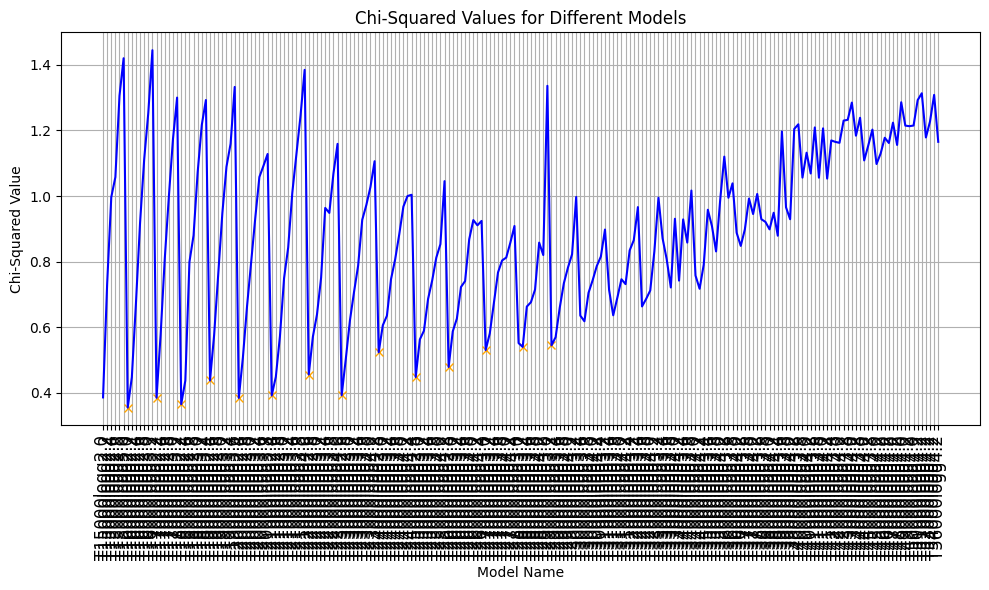

The minimum chi-squared: 0.35533796573761883
This is for model: T16000logg2.0
The models at the peaks are: ['T16000logg2.0' 'T17000logg2.2' 'T18000logg2.2' 'T19000logg2.4'
 'T20000logg2.4' 'T21000logg2.4' 'T22000logg2.6' 'T23000logg2.6'
 'T24000logg2.8' 'T25000logg2.8' 'T26000logg2.8' 'T27000logg3.0'
 'T28000logg3.2' 'T29000logg3.2']


In [15]:
peaks, _ = find_peaks(-np.array(list(chi2.values())), height=-0.6)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(peaks, [list(chi2.values())[i] for i in peaks], "x", color='orange')
plt.plot(list(chi2.keys()), list(chi2.values()), color='blue')
plt.xlabel('Model Name')
plt.ylabel('Chi-Squared Value')
plt.title('Chi-Squared Values for Different Models')
plt.xticks(rotation=90, ha='center', size=12)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

print(f"The minimum chi-squared: {chi2[min(chi2, key=chi2.get)]}")
print(f"This is for model: {min(chi2, key=chi2.get)}")
print(f"The models at the peaks are: {np.array(list(chi2.keys()))[peaks]}")

##### Plot the best model over the spectrum

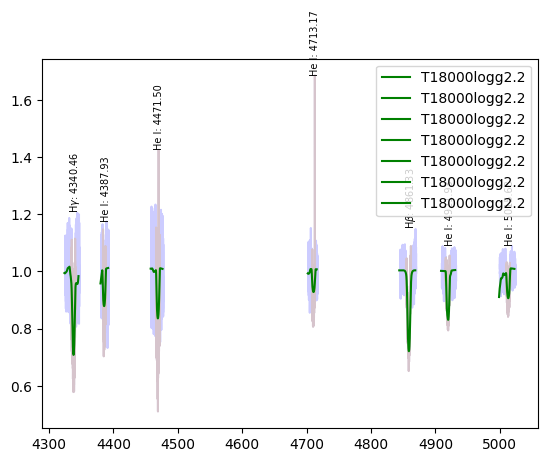

In [16]:
plot_best_model(spectra, models, _4U1538_52, 'T18000logg2.2')

Are the broadening and doppler shift function performing well?

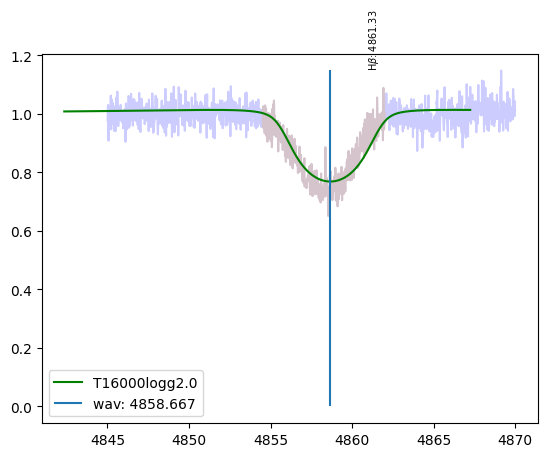

In [17]:
line = _4U1538_52['lines'][4]
model= models['T16000logg2.0']

# Select the spectrum that contains the spectral line
wav, flux = select_spectrum(spectra, line[0])

# Extract the spectral line from the spectrum
wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])

# Extract the line from the model
wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

# Linear fit to continuum
cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
# Normalize spectrum
flux /= cont_fit(wav)
flux_cont /= cont_fit(wav_cont)
flux_line /= cont_fit(wav_line)

# Dopplershift the model
wav_model = doppler_shift_spectrum(wav_model, vrad=-166.2297987071765)

# Apply doppler broadening
wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, 180)

plt.plot(wav, flux, color='blue', alpha=0.2)
plt.plot(wav_line, flux_line, color='orange', alpha=0.2)
plt.plot(wav_model, flux_model, color='green', label='T16000logg2.0')
plt.vlines(wav_model[list(flux_model).index(min(flux_model))], ymin=0, ymax=max(flux), label=f'wav: {round(wav_model[list(flux_model).index(min(flux_model))],3)}')

# Annotate each line with text vertically
plt.text(line[0], max(flux), line[1], ha='center', va='bottom', rotation=90, size=7)
plt.legend()
plt.show()

Save the fit results using pandas.

In [18]:
results = {'vsini80': chi2,
           'vsini90': chi2,
           'vsini100': chi2}

# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(results, orient='columns')

# Save DataFrame to CSV file
df.to_csv('FitResults/test.csv')

In [19]:
import json

data = {'key1': {'nested_key1': 'value1', 'nested_key2': 'value2'}}
with open('FitResults/result.json', 'w') as json_file:
    json.dump(results, json_file)

In [20]:

# Load the JSON file
with open('FitResults/result.json', 'r') as json_file:
    loaded_data = json.load(json_file)

loaded_data['vsini100'].keys()

dict_keys(['T15000logg2.0', 'T15000logg2.2', 'T15000logg2.4', 'T15000logg2.6', 'T15000logg2.8', 'T15000logg3.0', 'T16000logg2.0', 'T16000logg2.2', 'T16000logg2.4', 'T16000logg2.6', 'T16000logg2.8', 'T16000logg3.0', 'T16000logg3.2', 'T17000logg2.2', 'T17000logg2.4', 'T17000logg2.6', 'T17000logg2.8', 'T17000logg3.0', 'T17000logg3.2', 'T18000logg2.2', 'T18000logg2.4', 'T18000logg2.6', 'T18000logg2.8', 'T18000logg3.0', 'T18000logg3.2', 'T18000logg3.4', 'T19000logg2.4', 'T19000logg2.6', 'T19000logg2.8', 'T19000logg3.0', 'T19000logg3.2', 'T19000logg3.4', 'T19000logg3.6', 'T20000logg2.4', 'T20000logg2.6', 'T20000logg2.8', 'T20000logg3.0', 'T20000logg3.2', 'T20000logg3.4', 'T20000logg3.6', 'T20000logg3.8', 'T21000logg2.4', 'T21000logg2.6', 'T21000logg2.8', 'T21000logg3.0', 'T21000logg3.2', 'T21000logg3.4', 'T21000logg3.6', 'T21000logg3.8', 'T21000logg4.0', 'T22000logg2.6', 'T22000logg2.8', 'T22000logg3.0', 'T22000logg3.2', 'T22000logg3.4', 'T22000logg3.6', 'T22000logg3.8', 'T22000logg4.0', 'T2